## 1. Resolve K, R, t and K', R', t' from P and P'

In [1]:
import pygco
import numpy as np
import cv2
from PIL import Image
from pylab import *
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
DIST_NUM = 45
mLambda = 10

In [2]:
P = np.array([[1221.2270770,0.0000000,479.5000000],
             [0.0000000,1221.2270770,269.5000000],
             [0.0000000,0.0000000,1.0000000],
             [1.0000000000,0.0000000000,0.0000000000],
             [0.0000000000,1.0000000000,0.0000000000],
             [0.0000000000,0.0000000000,1.0000000000],
             [0.0000000000,0.0000000000,0.0000000000]])
Pp = np.array([[1221.2270770,0.0000000,479.5000000],
               [0.0000000,1221.2270770,269.5000000],
               [0.0000000,0.0000000,1.0000000],
               [0.9998813487,0.0148994942,0.0039106989],
               [-0.0148907594,0.9998865876,-0.0022532664],
               [-0.0039438279,0.0021947658,0.9999898146],
               [-9.9909793759,0.2451742154,0.1650832670]])
print(P, Pp)

[[1.22122708e+03 0.00000000e+00 4.79500000e+02]
 [0.00000000e+00 1.22122708e+03 2.69500000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]] [[ 1.22122708e+03  0.00000000e+00  4.79500000e+02]
 [ 0.00000000e+00  1.22122708e+03  2.69500000e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 9.99881349e-01  1.48994942e-02  3.91069890e-03]
 [-1.48907594e-02  9.99886588e-01 -2.25326640e-03]
 [-3.94382790e-03  2.19476580e-03  9.99989815e-01]
 [-9.99097938e+00  2.45174215e-01  1.65083267e-01]]


In [3]:
# def resolveMatrix(P):
#     # Do RQ decomposition:
#     K, R = linalg.rq(P)
#     KInverse = linalg.inv(K)
#     t = KInverse.dot(P[:, -1])
#     return K, R, t

In [4]:
# resolveMatrix(np.array([[2,2],[1,1]]))

## 2. Find X' from the Camera Matrices, and Do Graph Cut

Disparity is the times of et, thus, Disparities might need to be float for accuracy.

# generate a number of disparities as labels
def setDisparities(imgWidth, nDist):
    # Dist might need to be float
    distStep = int(imgWidth/nDist)
    dists = np.array(range(0, imgWidth, distStep))
    for eachDist in dists:
        if(eachDist!=0):
            eachDist-=1
    return dists

In [5]:
# generate a number of disparities as labels
def setDisparities1(maxDist, distStep):
    dists = np.array(range(0, maxDist, distStep))
    return dists

In [6]:
def getRgbDist(rgb1, rgb2):
    if(rgb1[0] > rgb2[0]):      
        rDiff = rgb1[0] - rgb2[0]
    else:
        rDiff = rgb2[0] - rgb1[0]
    if(rgb1[1] > rgb2[1]):      
        gDiff = rgb1[1] - rgb2[1]
    else:
        gDiff = rgb2[1] - rgb1[1]
    if(rgb1[2] > rgb2[2]):      
        bDiff = rgb1[2] - rgb2[2]
    else:
        bDiff = rgb2[2] - rgb1[2]
#     print((rDiff/3 + gDiff/3 + bDiff/3))
    return ((rDiff/3 + gDiff/3 + bDiff/3))
        

In [7]:
def buildGraphFromImages(img1, img2, dists, P, Pp):
    imgHeight = img1.shape[0] # range of vertical rows
    imgWidth = img1.shape[1] # range of horizontal columns
    
    nDists= dists.shape[0]
    # decompose P and P'
    K, R, T = P[0:3,:], P[3:6, :], P[-1, :]
    Kp, Rp, Tp = Pp[0:3,:], Pp[3:6, :], Pp[-1, :]
    mat2 = Kp.dot(np.transpose(Rp))
    mat1 = mat2.dot(R).dot(np.linalg.inv(K))
    mat3 = T-Tp
    
    #     print(Kp, Rp, Tp)
    # get prior term matrix/ pairwiseCost:
    pairwiseCost = np.zeros((nDists, nDists))
    for i in range(0, nDists):
        for j in range(0, nDists):
#             pairwiseCost[i][j] = getDist(dists[i], dists[j])
            pairwiseCost[i][j] = abs(dists[i]-dists[j])
    print(pairwiseCost)
    pairwiseCost = np.zeros((nDists, nDists))
    # get data term: edges, edgeWeights, unaryCosts
    nNodes = imgHeight*imgWidth
    nEdges = (2*imgHeight*imgWidth-imgHeight-imgWidth)
    
    edges = np.zeros((nEdges, 2))
    edgeWeights = np.ones((nEdges))
    unaryCosts = np.ones((nNodes, nDists))*(255)
    print(unaryCosts)
    
    # data cost /= smoothness prior
    # for each pixel x' on img1, get corresponded x'.
    edgeIndex = 0;
    for r in range(0, imgHeight):
        for c in range(0, imgWidth):
            # build the graph from right and bottom neighbor to all pixels
            nodeNo = r*imgWidth+c
            rightNodeNo = nodeNo+1
            bottomNodeNo = nodeNo+imgWidth
            if(rightNodeNo < nNodes and c < imgWidth-1):
                edges[edgeIndex,:] = np.array([nodeNo, rightNodeNo])
                edgeIndex+=1
            if(bottomNodeNo < nNodes and r < imgHeight-1):
                edges[edgeIndex,:] = np.array([nodeNo, bottomNodeNo])
                edgeIndex+=1
            # unary cost /= data term:
            for i in range(0, nDists):
                dist = dists[i]
                # make inhomogeneous coordinate of x:
                x = np.array([c, r, 1])
                # get x'
#                 temp1 = linalg.inv(K).dot(x)
#                 temp2 = R.dot(temp1)
#                 temp1 = linalg.inv(Rp).dot(temp2)
                xInfinite = mat1.dot(x)
                ep = dist*mat2.dot(mat3)
                xp = xInfinite + ep
                # normalize x'
                xp = xp/xp[2]
                # calculate distance between RGBx and RGBx' as
#                 print("xp:")
#                 print(xp)
                if xp[0] < imgHeight and xp[1] < imgWidth:
                    leftNodeRGB = img1[r, c]
                    rightNodeRGB = img2[int(xp[0]), int(xp[1])]
                    unaryCosts[nodeNo,i] = getRgbDist(leftNodeRGB, rightNodeRGB)
        # 
    return edges, edgeWeights, unaryCosts, pairwiseCost

In [8]:
# form an image from lables:
def formImg(orgImg, dists, labels):
    imgHeight = orgImg.shape[0]
    imgWidth = orgImg.shape[1]
    output = np.zeros((imgHeight, imgWidth, 1))
    grayScaleStep = 255/dists.shape[0]
    for r in range(0, imgHeight):
        for c in range(0, imgWidth):
            label = labels[r*imgWidth+c]
            output[r][c] = label*grayScaleStep
    return output

In [9]:
leftImg = cv2.imread('test00.jpg')
leftImg = cv2.cvtColor(leftImg, cv2.COLOR_BGR2RGB)
rightImg = cv2.imread('test09.jpg')
rightImg = cv2.cvtColor(rightImg, cv2.COLOR_BGR2RGB)

In [10]:
MAX_DIST = 64
DIST_STEP = 1

In [11]:
dists = setDisparities1(MAX_DIST, DIST_STEP)
print(dists)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


In [12]:
# form an image from lables:
def formImg1(orgImg, dists, labels):
    imgHeight = orgImg.shape[0]
    imgWidth = orgImg.shape[1]
    output = np.zeros((imgHeight, imgWidth, 1))
    grayScaleStep = 255/dists.shape[0]
    print(grayScaleStep)
    for r in range(0, imgHeight):
        for c in range(0, imgWidth):
            label = labels[r*imgWidth+c]
#             print(label)
#             print(label*grayScaleStep)
            output[r][c] = (label*grayScaleStep)/255
    return output

[[ 0.  1.  2. ... 61. 62. 63.]
 [ 1.  0.  1. ... 60. 61. 62.]
 [ 2.  1.  0. ... 59. 60. 61.]
 ...
 [61. 60. 59. ...  0.  1.  2.]
 [62. 61. 60. ...  1.  0.  1.]
 [63. 62. 61. ...  2.  1.  0.]]
[[255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 ...
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]]
3.984375


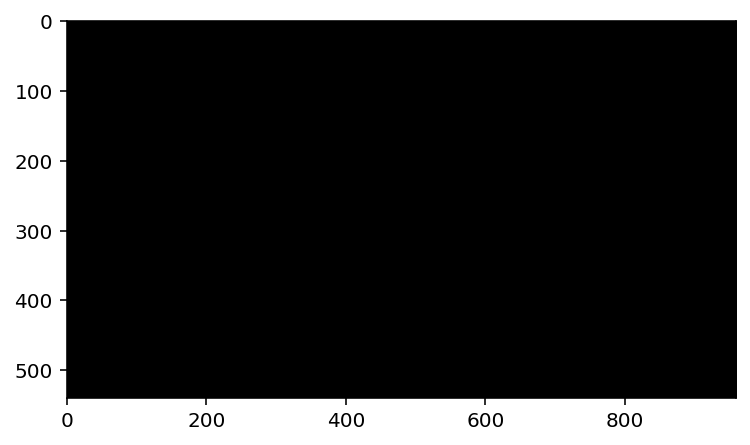

[0 0 0 ... 0 0 0]


In [13]:
edges, edgeWeights, unaryCosts, pairwiseCost  = buildGraphFromImages(leftImg, rightImg, dists, P, Pp)
labels = pygco.cut_general_graph(edges, mLambda*edgeWeights, unaryCosts, 1*pairwiseCost, n_iter=1)
output = formImg1(leftImg, dists, labels)
plt.imshow(output/255, cmap = "gray")
plt.show()
print(labels)